In [57]:
#https://www.w3schools.com/python/python_ml_k-means.asp

import os
import pandas as pd

os.chdir("/Users/rebecca/predicting-food-waste")

#load data
#data = pd.read_csv('daily_run_sheets.csv')
data = pd.read_csv('data.csv') #csv from Bella's ipynb

data.head()

,Event ID,Guest Count,Building Room,Street Address,SuppliesTime,Food Time,Event Start Time,End Time,Tier,Drop Steward,Pick Up Steward,Event Manager,Month,Event Duration (hrs),Number of Meals,Lbs Waste
0,143732,1,GSU,775 COMM AVE,6:30 AM,6:30 AM,6:30 AM,6:30 AM,1,Luis,NO P/U,NaN,September 2022,0.0,1.0,0.45
1,143733,1,GSU,775 COMM AVE,6:30 AM,6:30 AM,6:30 AM,6:30 AM,1,Antonio,NO P/U,NaN,September 2022,0.0,1.0,0.45
2,143734,1,GSU,775 COMM AVE,6:30 AM,6:30 AM,6:30 AM,6:30 AM,1,Luis,NO P/U,NaN,September 2022,0.0,1.0,0.45
3,143735,1,GSU,775 COMM AVE,6:30 AM,6:30 AM,6:30 AM,6:30 AM,1,Luis,NO P/U,NaN,September 2022,0.0,1.0,0.45
4,143736,1,GSU,775 COMM AVE,6:30 AM,6:30 AM,6:30 AM,6:30 AM,1,Luis,NO P/U,NaN,September 2022,0.0,1.0,0.45


In [58]:
def duration_total(df_name,start_timecol,end_timecol):
  duration = []
  start_time = df_name[start_timecol].str.strip()
  end_time = df_name[end_timecol].str.strip()

  for i in df_name.index:

    if start_time[i] == '0' or end_time[i] == '0' or start_time[i] == None or end_time[i] == None or type(start_time[i]) != str or type(end_time[i]) != str:
       
       duration += [None]
    
    else:
        #print(start_time[i])
        #print(start_time[i].split(' '))
        start_hrmin, start_period = map(str.strip, start_time[i].split(' '))
        start_hour, start_minute = map(str.strip, start_hrmin.split(':'))

        if end_time[i] == "12:01:30 AM":
            end_hour = "12"
            end_minute = "1"
            end_period = "AM"
            
        else: 
        #print(end_time[i])
        #print(end_time[i].split(' '))
            end_hrmin, end_period = map(str.strip, end_time[i].split(' '))
            end_hour = end_hrmin.split(':')[0].strip()
            end_minute = end_hrmin.split(':')[1].strip()
           
        
        start_hour = int(start_hour)
        start_minute = int(start_minute)
        end_hour = int(end_hour)
        end_minute = int(end_minute)
        
        # Convert hours to 24-hour format if necessary
        if start_period == 'PM' and start_hour != 12:
            start_hour += 12
        if start_period == 'AM' and start_hour == 12:
            start_hour += 12
        if end_period == 'AM' and end_hour == 12:
            end_hour += 12
        if end_period == 'PM' and end_hour != 12:
            end_hour += 12
        
        # Calculate time difference in minutes
        start_time_minutes = start_hour * 60 + start_minute
        end_time_minutes = end_hour * 60 + end_minute
        time_diff = end_time_minutes - start_time_minutes

        if time_diff < 0: #events with negative duration values (count as overnight)
            time_diff += 60*24

        duration += [time_diff]
        
        
  df_name["Duration"] = duration
  return df_name

In [61]:
data_w_duration = duration_total(data,"Event Start Time", "End Time")
data_w_duration["Duration"]

data_w_duration_no_na = data_w_duration.dropna(subset=["Duration"])

# Code to download dataset with durarion
data_w_duration
directory = "/Users/rebecca/predicting-food-waste"
filename = "data_w_duration.csv"
#data_w_duration.to_csv(os.path.join(directory, filename), index=False)

#data_w_duration.loc[data_w_duration['Duration'] < 0 ]  # code to check if duration is less than zero

#data_w_duration_no_na.loc[data_w_duration_no_na['Guest Count'] >5000 ]  # code to check if no. guest are more than 5k

#data_w_duration_no_na.loc[data_w_duration_no_na['Street Address'] == 'Various' ] # code with location 'Various'

data_no_various = data_w_duration_no_na.loc[data_w_duration_no_na['Street Address'].str.strip() != 'VARIOUS' ] #rmv

data_no_various['Tier']= data_no_various['Tier'].str.replace('.0', '') #change tier cat



/var/folders/9g/mmlvj2fj23x6r6tr77txfdvc0000gn/T/ipykernel_82547/3277098209.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  data_no_various['Tier']= data_no_various['Tier'].str.replace('.0', '') #change tier cat
/var/folders/9g/mmlvj2fj23x6r6tr77txfdvc0000gn/T/ipykernel_82547/3277098209.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_various['Tier']= data_no_various['Tier'].str.replace('.0', '') #change tier cat


# K Means for Guest Count vs Duration


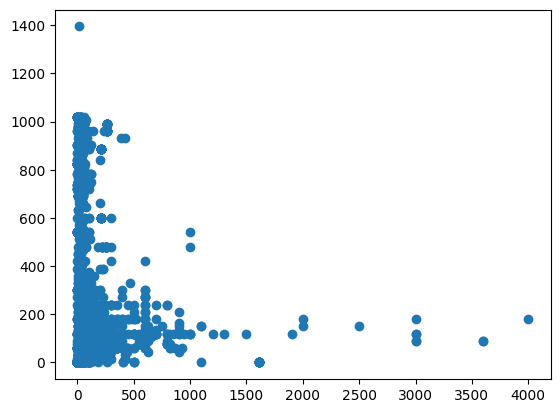

In [62]:
import matplotlib.pyplot as plt

x = data_no_various["Guest Count"]
y = data_no_various["Duration"]

plt.scatter(x, y)
plt.show()


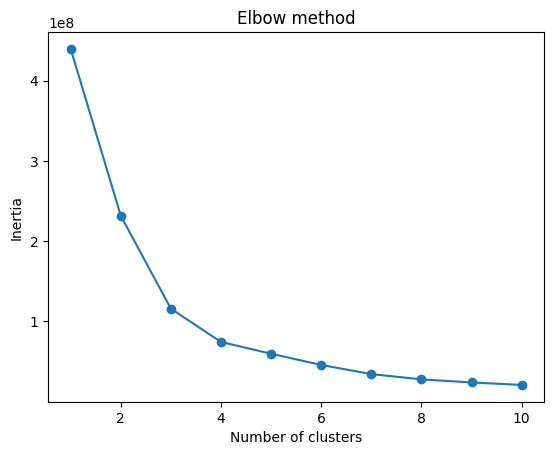

In [63]:
from sklearn.cluster import KMeans

data = list(zip(x, y))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

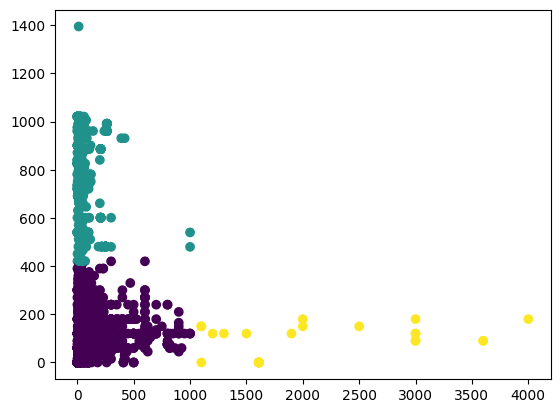

In [64]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)

plt.scatter(x, y, c=kmeans.labels_)
plt.show()

# 3 main types of events:
# - Short duration and few guests (<= 1000 guests and <= 400 min)
# - Long duration and few guests (> 1000 guests and <= 400 min)
# - Short duration and many guests (< 1000 guests and > 400 min)

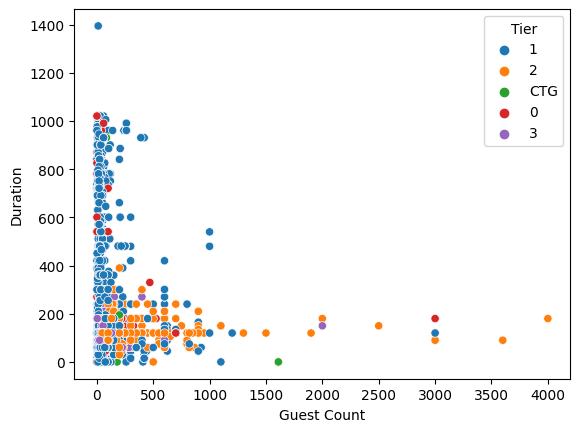

In [65]:
# Check if theres a correlation to Tiers

import numpy as np

x = data_no_various["Guest Count"]
y = data_no_various["Duration"]
num = len(data_no_various["Guest Count"])
labels = np.random.choice(['a', 'b', 'c'], num)
#labels =data["Tier"]
#plt.scatter(x, y, c= labels )

import seaborn as sns
sns.scatterplot(x = 'Guest Count', y=  'Duration',data = data_no_various, hue='Tier')

plt.show()

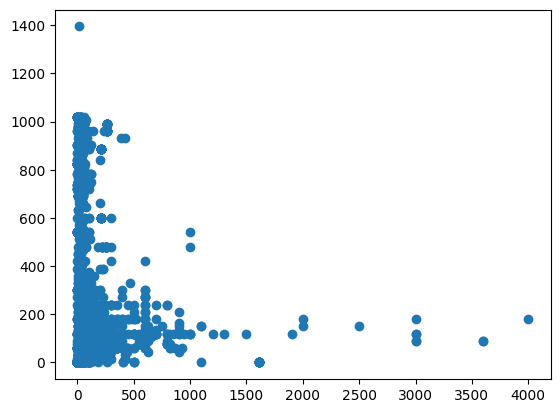

In [66]:
# K means Drop and Go vs Full Serve

x = data_no_various["Guest Count"]
y = data_no_various["Duration"]

plt.scatter(x, y)
plt.show()

In [72]:
# Cleaning Pick up/ Drop off 

def pickupcol(data):
    data['Drop Steward']= data_no_various['Drop Steward'].str.replace('NO P/U', '') #clean
    data['Pick Up Steward']= data_no_various['Pick Up Steward'].str.replace('NO P/U', '') #clean
    data['Drop Steward']= data_no_various['Drop Steward'].str.replace('N/A', '') #clean
    data['Pick Up Steward']= data_no_various['Pick Up Steward'].str.replace('N/A', '') #clean
    for i in data:
        if (data['Pick Up Steward'].iloc[i] == '' or data['Pick Up Steward'].iloc[i] == None) and (data['Drop Steward'].iloc[i] == '' or data['Drop Steward'].iloc[i] == None):
            data["DnG"].iloc[i] = 0
        data["DnG"].iloc[i] = 1
    return data

pickupcol(data_no_various)


/var/folders/9g/mmlvj2fj23x6r6tr77txfdvc0000gn/T/ipykernel_82547/519611383.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Drop Steward']= data_no_various['Drop Steward'].str.replace('NO P/U', '') #clean
/var/folders/9g/mmlvj2fj23x6r6tr77txfdvc0000gn/T/ipykernel_82547/519611383.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Pick Up Steward']= data_no_various['Pick Up Steward'].str.replace('NO P/U', '') #clean
/var/folders/9g/mmlvj2fj23x6r6tr77txfdvc0000gn/T/ipykernel_82547/519611383.py:

TypeError: Cannot index by location index with a non-integer key

In [ ]:
# Top Buildings >1/2 Ton

#Cat of events box plot

In [ ]:
#Drop and Go box plot